In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

import dual_sourcing
from utility import convergence_test, evaluate
from TBS_module import TBS, find_optimal_TBS
from nn_model import Model, nn_policy
from a2c import initialize, A2C

Average reward: -1131.102110211021


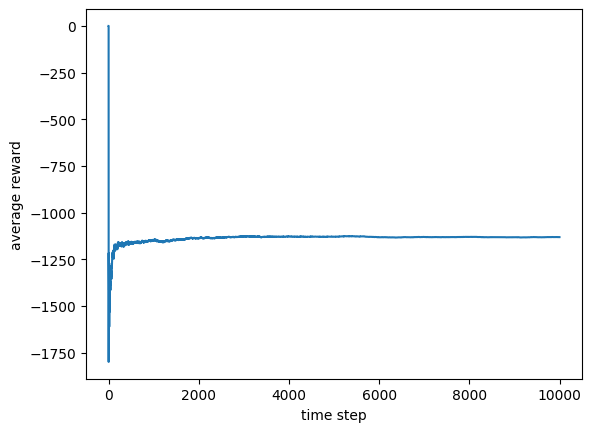

In [2]:
CONFIG = {'Lr': 5, 'Le': 1, 'cr': 100, 'ce': 105, 'lambda': 10,
          'h': 1, 'b': 19, 'starting_state': [0]*7, 'max_order': 20, 'max_inventory': 1000}

env = gym.make('DualSourcing-v0', config=CONFIG)
env.seed(0)

state_dim = env.observation_space.shape[0]
action_space = env.nA

torch.manual_seed(0)
learning_rate = 0.01

model = Model(state_dim, action_space, 32)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

r = 5
S = 3
initialize(env, model, r, S)

m = env.max_order + 1
plt.figure()
convergence_test(env, 10000, nn_policy, env, model, m)
plt.show()

In [3]:
maxit = 100
rollout = 1000
param = {'env_seed': 0, 'torch_seed': 0, 'number_of_actors': 1, 'proportion': 0.5}

A2C(env, model, optimizer, maxit, rollout, param)

Average reward: -1056.892289228923


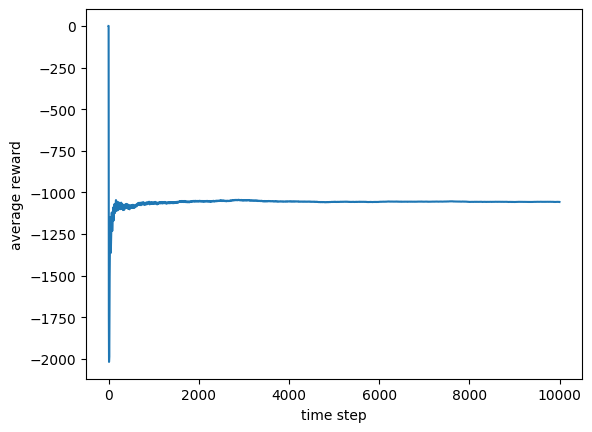

In [4]:
plt.figure()
convergence_test(env, 10000, nn_policy, env, model, m)
plt.show()